In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
from importlib import reload


In [9]:
# Weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, weights = None):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
    def forward(self, input, target):
        return torch.mean(self.weights * (input - target) ** 2)

In [10]:
# Load data
data = pd.read_csv('Data/10sec.csv')

# Deserialize the strings back into NumPy arrays
data['x1'] = data['x1'].apply(lambda x: np.array(x.split(), dtype=float))
data['x2'] = data['x2'].apply(lambda x: np.array(x.split(), dtype=float))

# Put data into tensor
u = torch.stack(data['u'].apply(lambda x: torch.tensor([x])).tolist()).to(dtype=torch.float32)
x1 = torch.stack(data['x1'].apply(lambda x: torch.tensor(x)).tolist()).to(dtype=torch.float32)
x2 = torch.stack(data['x2'].apply(lambda x: torch.tensor(x)).tolist()).to(dtype=torch.float32)

# Put data into in and output tensor
x = torch.cat((u, x1), dim=1)
y = x2

# Split data into training and validation set
x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_val = x[int(0.8*len(x)):]
y_val = y[int(0.8*len(y)):]


In [11]:
import model
reload(model)
from model import Neural_network

# Summarize the network
summary(Neural_network(), (1, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              40
            Linear-2                   [-1, 16]             144
            Linear-3                   [-1, 64]           1,088
            Linear-4                    [-1, 3]             195
Total params: 1,467
Trainable params: 1,467
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [12]:
# Set hyperparameters
epochs = 600
batch_size = 8
learning_rate = 0.0001

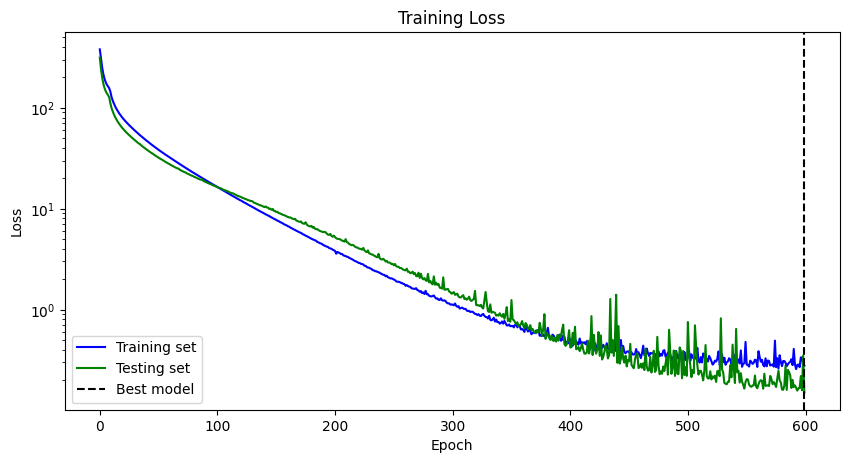

Final loss:
Train:        2.5316e-01
Test:         1.5048e-01
Validation:   2.1254e-01


In [13]:
# Initialize the network and the optimizer
net = Neural_network() 
loss_func = WeightedMSELoss(weights = torch.tensor([1000, 100, 1], dtype=torch.float32))
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# Split the training set into a training and validation set
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

# Number of batches
net.train() # set network to training mode
Index = np.arange(len(y_train_train)) #Index, so we can randomly shuffle inputs and outputs

np.random.seed(0) # set random seed for shuffling

loss_per_epoch = []
loss_per_epoch_test = []

# Initialize the plot
%matplotlib qt
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.set_yscale('log')

# Initialize loop variables
batches = int(np.floor(len(y_train_train)/batch_size)) # how many batches are there when dividing the whole data set
best_model = None
best_loss = np.inf
for epoch in range(1, epochs + 1):
    if(epoch == 200):
        otpimizer = optim.Adam(net.parameters(), lr = learning_rate/10)

    np.random.shuffle(Index) # shuffle indices, so batches have randomly selected samples
    
    loss_epoch = 0
    
    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = x_train[Index_batch] # Get respective input data
        y_batch = y_train[Index_batch] # Get respective output data
        
        # delete gradients from optimizer (otherwise, gradients are cummulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(x_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()
        
        loss_epoch += loss
    
    # Mean training loss per epoch
    loss_epoch /= batches
    loss_per_epoch.append(loss_epoch.item())


    # Validation loss per epoch
    loss_test = loss_func(net(x_train_test), y_train_test)
    if loss_test < best_loss:
        better_star = "*"
        best_loss = loss_test
        best_model = deepcopy(net)
    else:
        better_star = ""
    loss_per_epoch_test.append(loss_test.item())

    #print('Loss for epoch {:02d}/{}     train: {:0.4e}     test: {:0.4e} {star}'.format(epoch, epochs, loss_epoch, loss_test, star = better_star) )    

    if (epoch-1) % 10 == 0:
        ax.lines.clear()
        ax.plot(loss_per_epoch, color = 'blue', label = 'Training set')
        ax.plot(loss_per_epoch_test, color = 'green', label = 'Testing set')
        ax.axvline(x = np.argmin(loss_per_epoch_test), color = 'black', linestyle = '--', label = 'Best model')
        ax.legend()
        plt.draw()
        plt.pause(0.01)

# Plot the results inline
plt.close()
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.set_yscale('log')
ax.plot(loss_per_epoch, color = 'blue', label = 'Training set')
ax.plot(loss_per_epoch_test, color = 'green', label = 'Testing set')
ax.axvline(x = np.argmin(loss_per_epoch_test), color = 'black', linestyle = '--', label = 'Best model')
ax.legend()
plt.show()

# Evaluate the validation loss
best_model.eval() 
with torch.no_grad(): 
    y_train_pred = best_model(x_train_train)
    y_test_pred = best_model(x_train_test)
    y_val_pred = best_model(x_val)

loss_train = loss_func(y_train_pred, y_train_train)
loss_test = loss_func(y_test_pred, y_train_test)
loss_val = loss_func(y_val, y_val_pred)

print('Final loss:\nTrain:        {:0.4e}\nTest:         {:0.4e}\nValidation:   {:0.4e}'.format(loss_train, loss_test, loss_val) )

# Save the model, both as pytorch and traced file for matlab
torch.save(best_model.state_dict(), 'Models/10sec_norelu.pth')
traced_model = torch.jit.trace(best_model, torch.randn(1, 4))
traced_model.save('Models/10sec_norelu.pt')

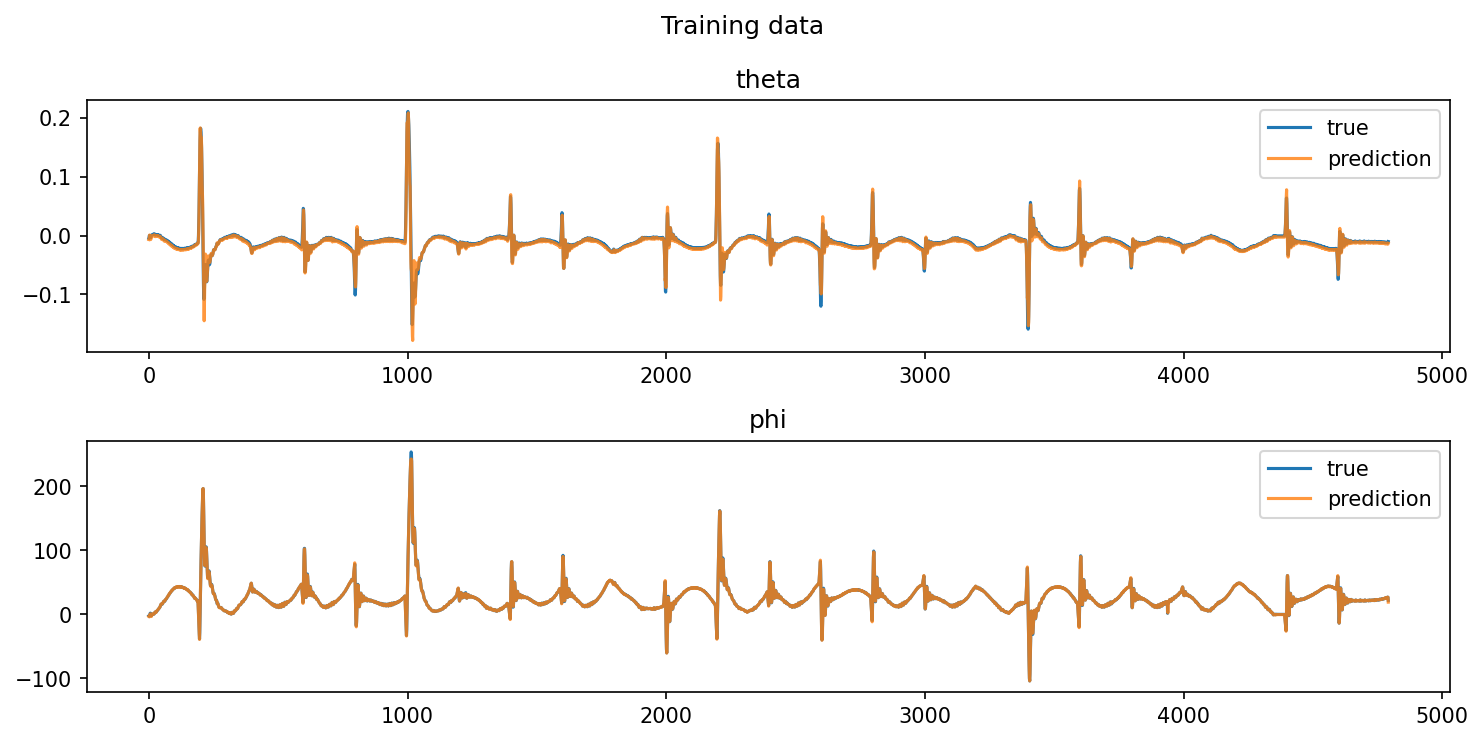

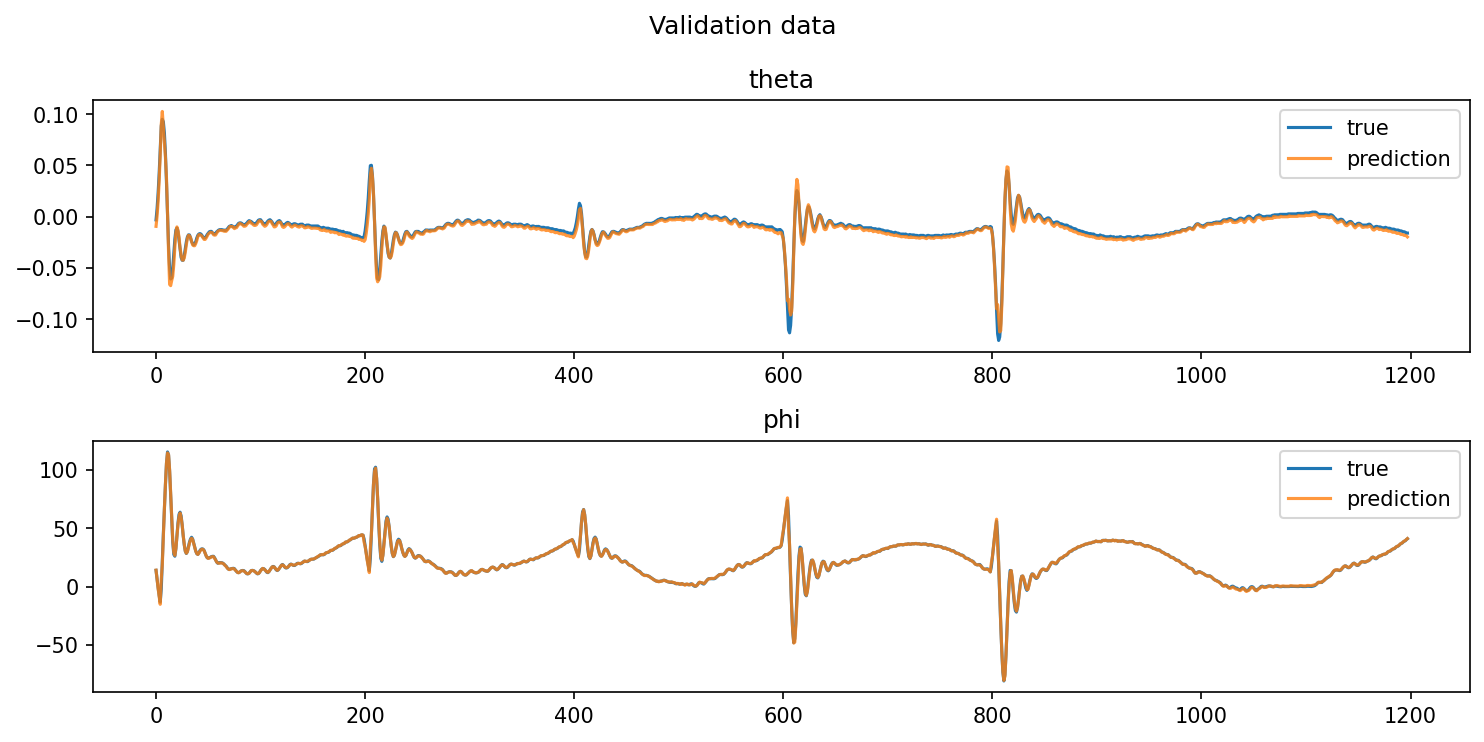

In [14]:
# Show plots of training and validation data as a sequence
data = loadmat('Data/10sec.mat')
ignoreSteps = 10
t = torch.tensor(data['t'][ignoreSteps:,0], dtype=torch.float64)
u = torch.reshape(torch.tensor((data['u'])[0,0,ignoreSteps:], dtype=torch.float64), (len(t),1))
y = torch.tensor(data['y'][ignoreSteps:,:3], dtype=torch.float64)
xhat = torch.tensor(data['xhat'][ignoreSteps:,:], dtype=torch.float64)

# Training
net_out = torch.tensor(np.zeros((len(x_train), 3)))
best_model.eval()
for i in range(len(x_train)):
    with torch.no_grad():
        net_out[i,:] = best_model(x_train[i,:])

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,5), dpi = 150)
ax1.plot(y_train[:,0], label = "true")
ax1.plot(net_out[:,0], label = "prediction", alpha = 0.8)
ax1.set_title("theta")
ax1.legend()
ax2.plot(y_train[:,2], label = "true")
ax2.plot(net_out[:,2], label = "prediction", alpha = 0.8)
ax2.set_title("phi")
ax2.legend()
plt.suptitle("Training data")
plt.tight_layout()
plt.show()

# Validation
net_out = torch.tensor(np.zeros((len(x_val), 3)))
best_model.eval()
for i in range(len(x_val)):
    with torch.no_grad():
        net_out[i,:] = best_model(x_val[i,:])

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (10,5), dpi = 150)
ax1.plot(y_val[:,0], label = "true")
ax1.plot(net_out[:,0], label = "prediction", alpha = 0.8)
ax1.set_title("theta")
ax1.legend()
ax2.plot(y_val[:,2], label = "true")
ax2.plot(net_out[:,2], label = "prediction", alpha = 0.8)
ax2.set_title("phi")
ax2.legend()
plt.suptitle("Validation data")
plt.tight_layout()
plt.show()